In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, RepeatedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from category_encoders import TargetEncoder
import sklearn
import zipfile
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
warnings.simplefilter('ignore', ConvergenceWarning)

# Unzip data

In [3]:
with zipfile.ZipFile('housedata.zip', 'r') as z:
    z.extractall('./')

In [4]:
data = pd.read_csv('data.csv')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


# 2.1 
Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

Drop the date column and all rows with prices <= 0

In [5]:
data = data[data.price > 0.0]
data = data.drop(columns='date')

Get the target 'price' column and remove it from the dataframe. Remove 'street' and 'country' columns

In [6]:
price = data['price']
data = data.drop(columns=['price', 'country', 'street'])

The features which are continuous include sqft_living, sqft_lot, sqft_above, sqft_basement, as well as yr_built and yr_renovated. The features which are categorical include waterfront, view, condition, statezip, and city. The features bedrooms, bathrooms, and floors can be defined as discrete features. As you cannot have an infinite number of inbetween values (i.e between 1 and 1.5 bathrooms, you cannot have 1.25), and the number of categories are finite for these features (i.e the number of unique values is a small finite number), they have been treated as categorical for the purpose of this assignment. As street and country are not useful for the task of predicting price, these columns have been dropped from the dataframe.

## 2.2 
Visualize the univariate distribution of each continuous feature, and the distribution of the
target. Do you notice anything? Is there something that might require special treatment?

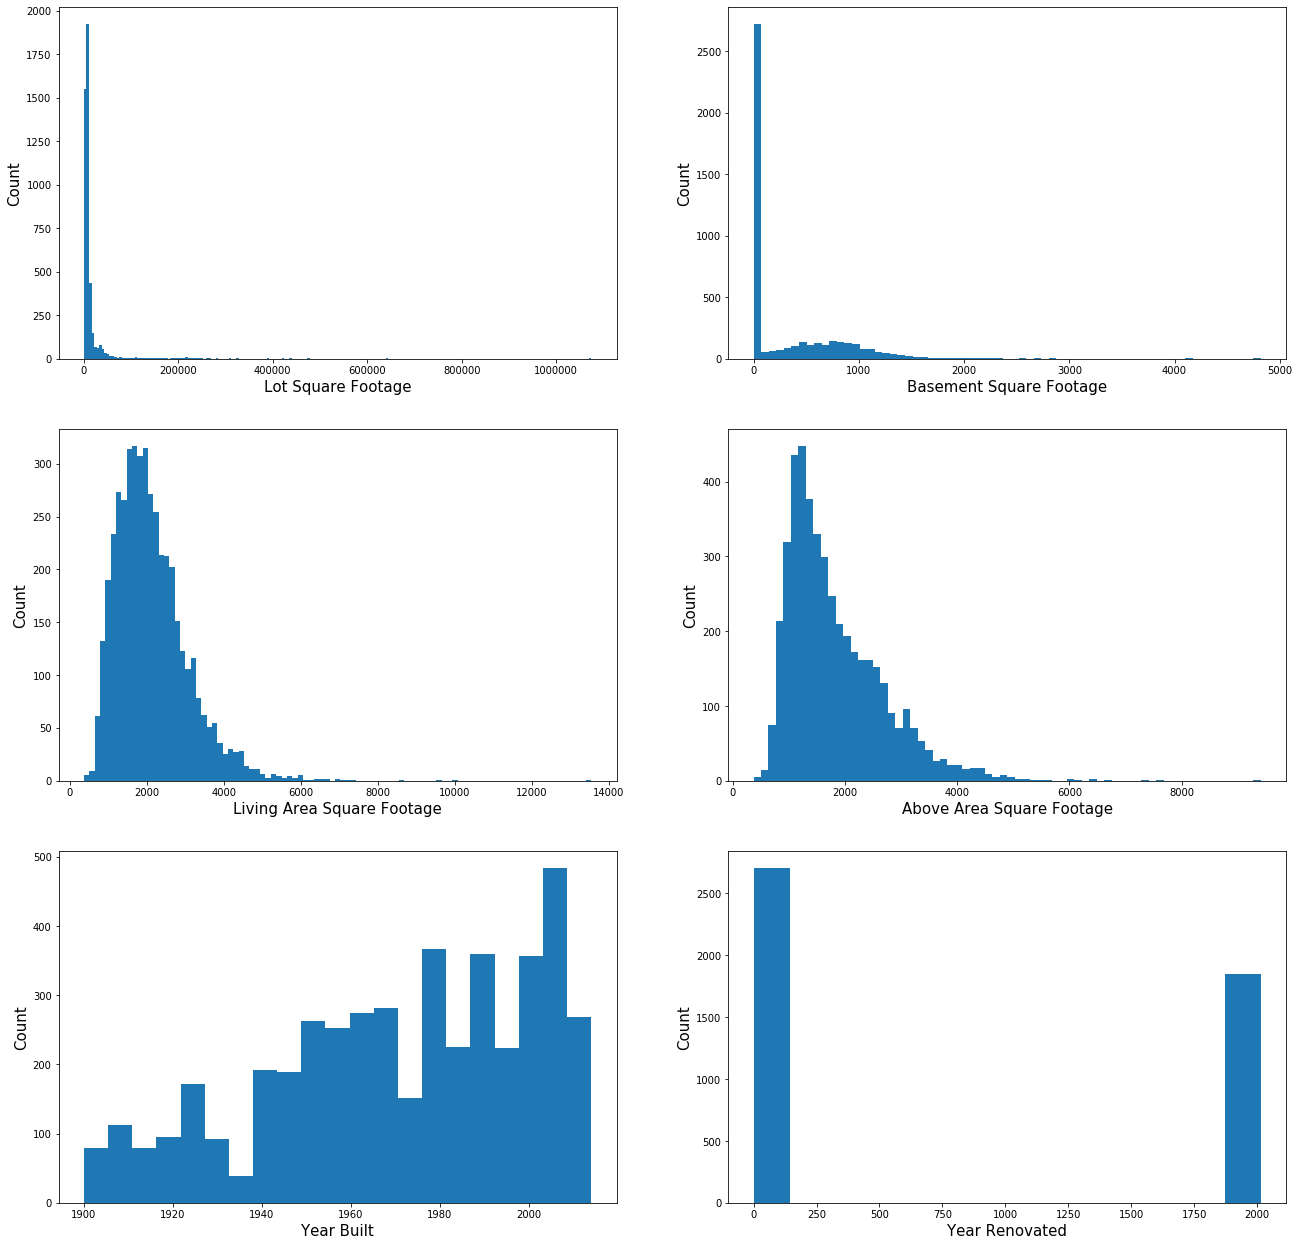

In [153]:
fig, ax = plt.subplots(3, 2, figsize=(22,22))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.hist(data['sqft_lot'], bins=200)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('Lot Square Footage', fontsize=15)

ax2.hist(data['sqft_basement'], bins='auto')
ax2.set_ylabel('Count', fontsize=15)
ax2.set_xlabel('Basement Square Footage', fontsize=15)

ax3.hist(data['sqft_living'], bins='auto')
ax3.set_ylabel('Count', fontsize=15)
ax3.set_xlabel('Living Area Square Footage', fontsize=15)

ax4.hist(data['sqft_above'], bins='auto')
ax4.set_ylabel('Count', fontsize=15)
ax4.set_xlabel('Above Area Square Footage', fontsize=15)

ax5.hist(data['yr_built'], bins='auto')
ax5.set_ylabel('Count', fontsize=15)
ax5.set_xlabel('Year Built', fontsize=15)

ax6.hist(data['yr_renovated'], bins='auto')
ax6.set_ylabel('Count', fontsize=15)
ax6.set_xlabel('Year Renovated', fontsize=15)
plt.show()

Visualize the target

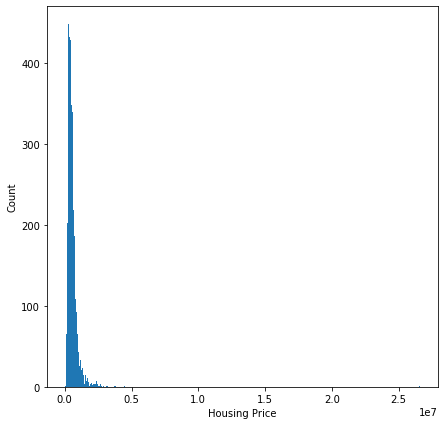

In [154]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.hist(price, bins=500)
ax.set_xlabel('Housing Price')
ax.set_ylabel('Count')
plt.show()

Do you notice anything? Is there something that might require special treatment?

Looking at the distributions of the continuous data and the target, one obvious difference is the range of values presented. For example, 'sqft_lot' has a right tail with values which are in the range of 20000, which is signifcantly higher than majority of the values/ranges of the other continuous features. Therefore, scaling the data will be important. Furthermore, 'sqft_basement' has a significant number of 0's and therefore, may require special treatment. In order to deal with this, an additional column has been added (see below) which is a categorical feature, encoding whether or not there a basement (i.e. 1 if there is a basement/non-zero value for the 'sqft_basement' and 0 otherwise). Also, looking at the year renovated, there is also a column full of zeros. When comparing this to the original data.dat file, the 0's in this column have been used to replace 'NaN' and therefore, imputing will be needed to replace the 0's in the year renovated column. Finally, the target variable shows a skew in its distribution. To deal with this, a log-transformation was considered and used but as it did not help with the regression results, it was not used for parts 2.4-2.6

Add an additional 'has_basement' column

In [7]:
data['has_basement'] = 0
data.loc[data['sqft_basement'] > 0, 'has_basement'] = 1

## 2.3 
Visualize the dependency of the target on each continuous feature (2d scatter plot).

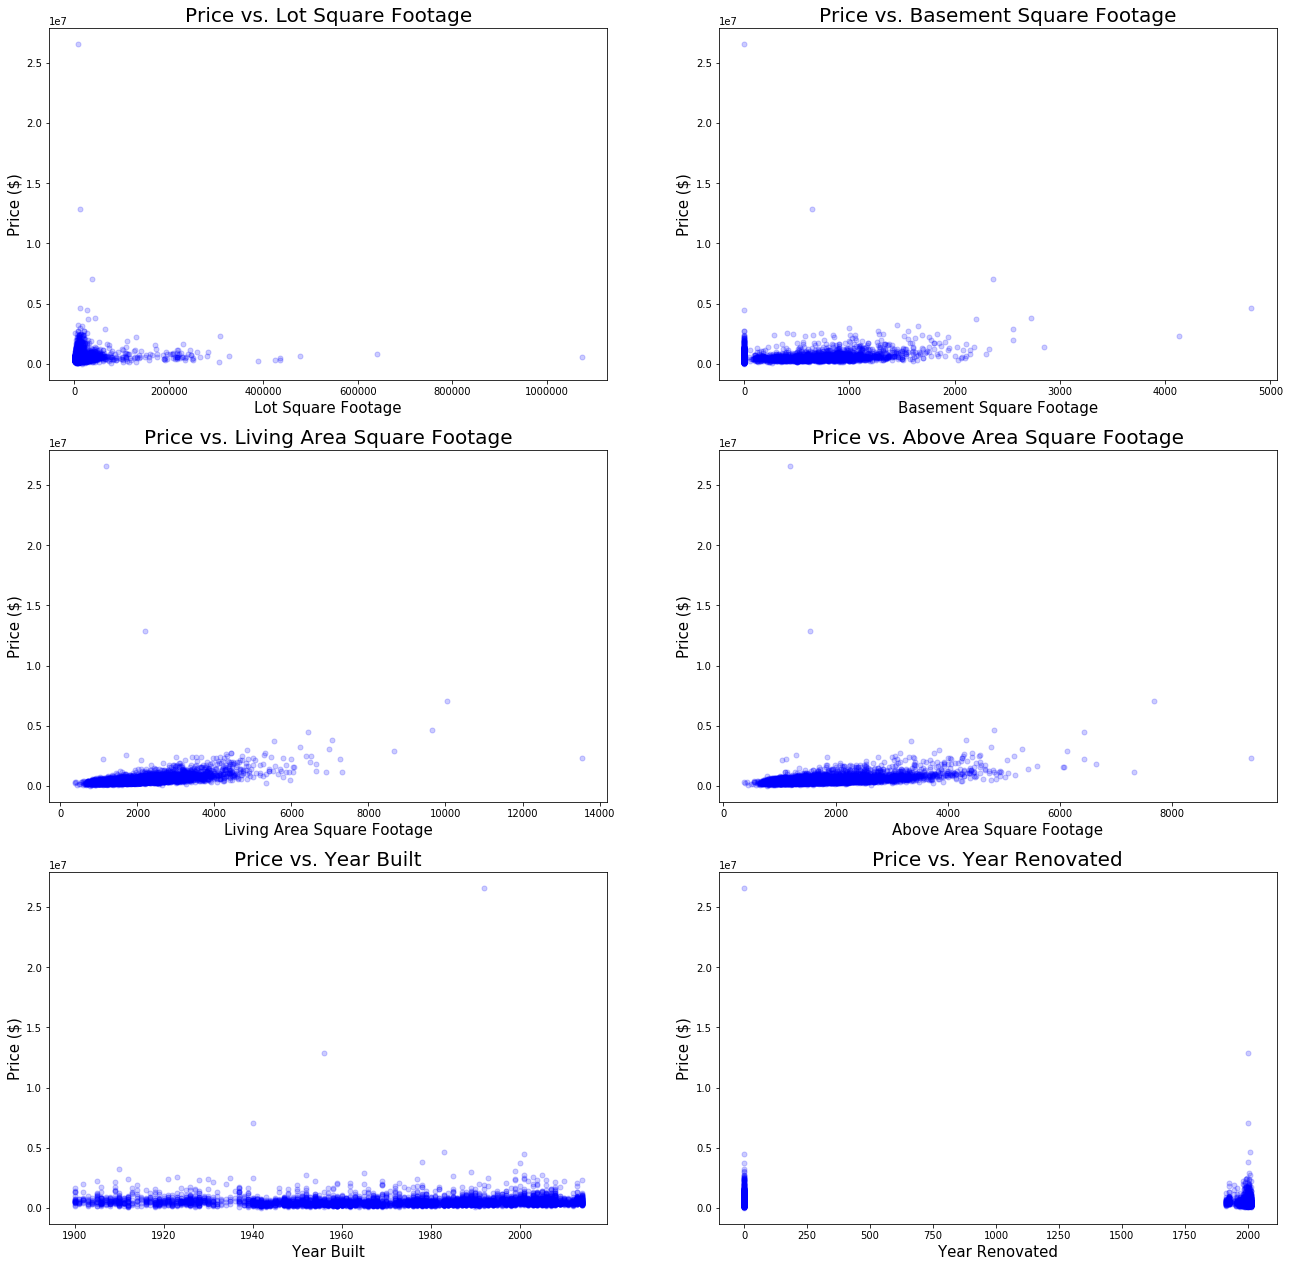

In [180]:
fig, ax = plt.subplots(3, 2, figsize=(22,22))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(data['sqft_lot'], price, 'bo', alpha=0.2, markersize=5)
ax1.set_ylabel('Price ($)', fontsize=15)
ax1.set_xlabel('Lot Square Footage', fontsize=15)
ax1.set_title('Price vs. Lot Square Footage', fontsize=20)

ax2.plot(data['sqft_basement'], price, 'bo', alpha=0.2, markersize=5)
ax2.set_ylabel('Price ($)', fontsize=15)
ax2.set_xlabel('Basement Square Footage', fontsize=15)
ax2.set_title('Price vs. Basement Square Footage', fontsize=20)

ax3.plot(data['sqft_living'], price, 'bo', alpha=0.2, markersize=5)
ax3.set_ylabel('Price ($)', fontsize=15)
ax3.set_xlabel('Living Area Square Footage', fontsize=15)
ax3.set_title('Price vs. Living Area Square Footage', fontsize=20)

ax4.plot(data['sqft_above'], price, 'bo', alpha=0.2, markersize=5)
ax4.set_ylabel('Price ($)', fontsize=15)
ax4.set_xlabel('Above Area Square Footage', fontsize=15)
ax4.set_title('Price vs. Above Area Square Footage', fontsize=20)

ax5.plot(data['yr_built'], price, 'bo', alpha=0.2, markersize=5)
ax5.set_ylabel('Price ($)', fontsize=15)
ax5.set_xlabel('Year Built', fontsize=15)
ax5.set_title('Price vs. Year Built', fontsize=20)

ax6.plot(data['yr_renovated'], price, 'bo', alpha=0.2, markersize=5)
ax6.set_ylabel('Price ($)', fontsize=15)
ax6.set_xlabel('Year Renovated', fontsize=15)
ax6.set_title('Price vs. Year Renovated', fontsize=20)
plt.show()

In [8]:
# Separate features based on the type of preprocessing required
area = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
categorical = ['waterfront', 'city', 'condition', 'view', 'has_basement', 'bedrooms', 'bathrooms', 'floors']
state = ['statezip']
year = ['yr_built', 'yr_renovated']

## 2.4
Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, price, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=0)

As part of the preprocessing, impute all missing year values with the most frequent. Use target encoding for the statezip column and One-hot encode all categorical data

In [11]:
yr_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0))])
cat_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0)),
                           ('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))])
target_processing = Pipeline([('encode', TargetEncoder())])

preprocess = make_column_transformer((yr_processing, year),
                                     (cat_processing, categorical),
                                     (target_processing, state),
                                     remainder='passthrough')

In [13]:
lin_reg_pipe = make_pipeline(preprocess, LinearRegression())
lin_reg = cross_val_score(lin_reg_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lin_reg)

0.6212909555143789

In [14]:
ridge_pipe = make_pipeline(preprocess, Ridge(max_iter=1000))
ridge = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(ridge)

0.5732155870020962

In [15]:
lasso_pipe = make_pipeline(preprocess, Lasso(max_iter=1000))
lasso = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lasso)

0.61887467841991

In [16]:
en_pipe = make_pipeline(preprocess, ElasticNet(max_iter=1000))
en = cross_val_score(en_pipe, X_train, y_train, cv=cv_strategy)
np.mean(en)

0.6084515295045014

Add scaling on continuous data

In [23]:
cont_processing = Pipeline([('scale', preprocessing.StandardScaler())])
preprocess_with_ss = make_column_transformer((yr_processing, year),
                                     (cat_processing, categorical),
                                     (cont_processing, continuous),
                                     (target_processing, state),
                                     remainder='passthrough')

In [24]:
lin_reg_pipe = make_pipeline(preprocess_with_ss, LinearRegression())
lin_reg_ss = cross_val_score(lin_reg_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lin_reg_ss)

0.6207354400992245

In [25]:
ridge_pipe = make_pipeline(preprocess_with_ss, Ridge(max_iter=1000))
ridge_ss = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(ridge_ss)

0.2898820623120502

In [26]:
lasso_pipe = make_pipeline(preprocess_with_ss, Lasso(max_iter=1000))
lasso_ss = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lasso_ss)

0.6187419959425993

In [27]:
en_pipe = make_pipeline(preprocess_with_ss, ElasticNet(max_iter=1000))
en = cross_val_score(en_pipe, X_train, y_train, cv=cv_strategy)
np.mean(en)

0.5814569433637111

Scaling the data did not help. Especially in the case of ridge regression, the mean cross validation score became significantly worse. In all the other cases, the average scores became slightly worse or slightly better but the change was insignificant compared to when no scaling was done on the continuous data.

# 2.5 
Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

As scaling did not show improvement, it has not been used for the remaining parts of the assignment.

In [59]:
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=0)
yr_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0))])
cat_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0)),
                           ('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))])
target_processing = Pipeline([('encode', TargetEncoder())])

preprocess = make_column_transformer((yr_processing, year),
                                     (cat_processing, categorical),
                                     (target_processing, state),
                                     remainder='passthrough')

In [60]:
ridge_pipe_new = make_pipeline(preprocess, Ridge(max_iter=1000))
param_grid = {'ridge__alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(ridge_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
ridge_grid.best_score_

0.5732155870126225

In [66]:
lasso_pipe_new = make_pipeline(preprocess, Lasso(max_iter=1000))
param_grid = {'lasso__alpha': np.logspace(-3,3,7)}
lasso_grid = GridSearchCV(lasso_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_

0.630417316628477

In [62]:
en_pipe_new = make_pipeline(preprocess, ElasticNet(max_iter=1000))
param_grid = {'elasticnet__alpha': np.logspace(-3,3,7)}
en_grid = GridSearchCV(en_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
en_grid.fit(X_train, y_train)
en_grid.best_score_

0.6302231933068319

In [63]:
param_grid = {'elasticnet__l1_ratio': np.logspace(-3,0,7)}
en_grid_l1 = GridSearchCV(en_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
en_grid_l1.fit(X_train, y_train)
en_grid_l1.best_score_

0.61887467841991

In [64]:
print(ridge_grid.best_params_)
print(lasso_grid.best_params_)
print(en_grid.best_params_)
print(en_grid_l1.best_params_)

{'ridge__alpha': 0.1}
{'lasso__alpha': 1000.0}
{'elasticnet__alpha': 0.01}
{'elasticnet__l1_ratio': 1.0}


Evaluate on the best model

In [67]:
lasso_grid.score(X_test, y_test)

0.7130866882120852

## Do the results improve?


In [68]:
ridge_df = pd.DataFrame(ridge_grid.cv_results_)
ridge_mean_test_score = ridge_df['mean_test_score']
ridge_mean_train_score = ridge_df['mean_train_score']
ridge_alpha_param = ridge_df['param_ridge__alpha']

lasso_df = pd.DataFrame(lasso_grid.cv_results_)
lasso_mean_test_score = lasso_df['mean_test_score']
lasso_mean_train_score = lasso_df['mean_train_score']
lasso_alpha_param = lasso_df['param_lasso__alpha']

en_df = pd.DataFrame(en_grid.cv_results_)
en_mean_test_score = en_df['mean_test_score']
en_mean_train_score = en_df['mean_train_score']
en_alpha_param = en_df['param_elasticnet__alpha']

en_df_l1 = pd.DataFrame(en_grid_l1.cv_results_)
en_mean_test_score_l1 = en_df_l1['mean_test_score']
en_mean_train_score_l1 = en_df_l1['mean_train_score']
en_l1_param = en_df_l1['param_elasticnet__l1_ratio']

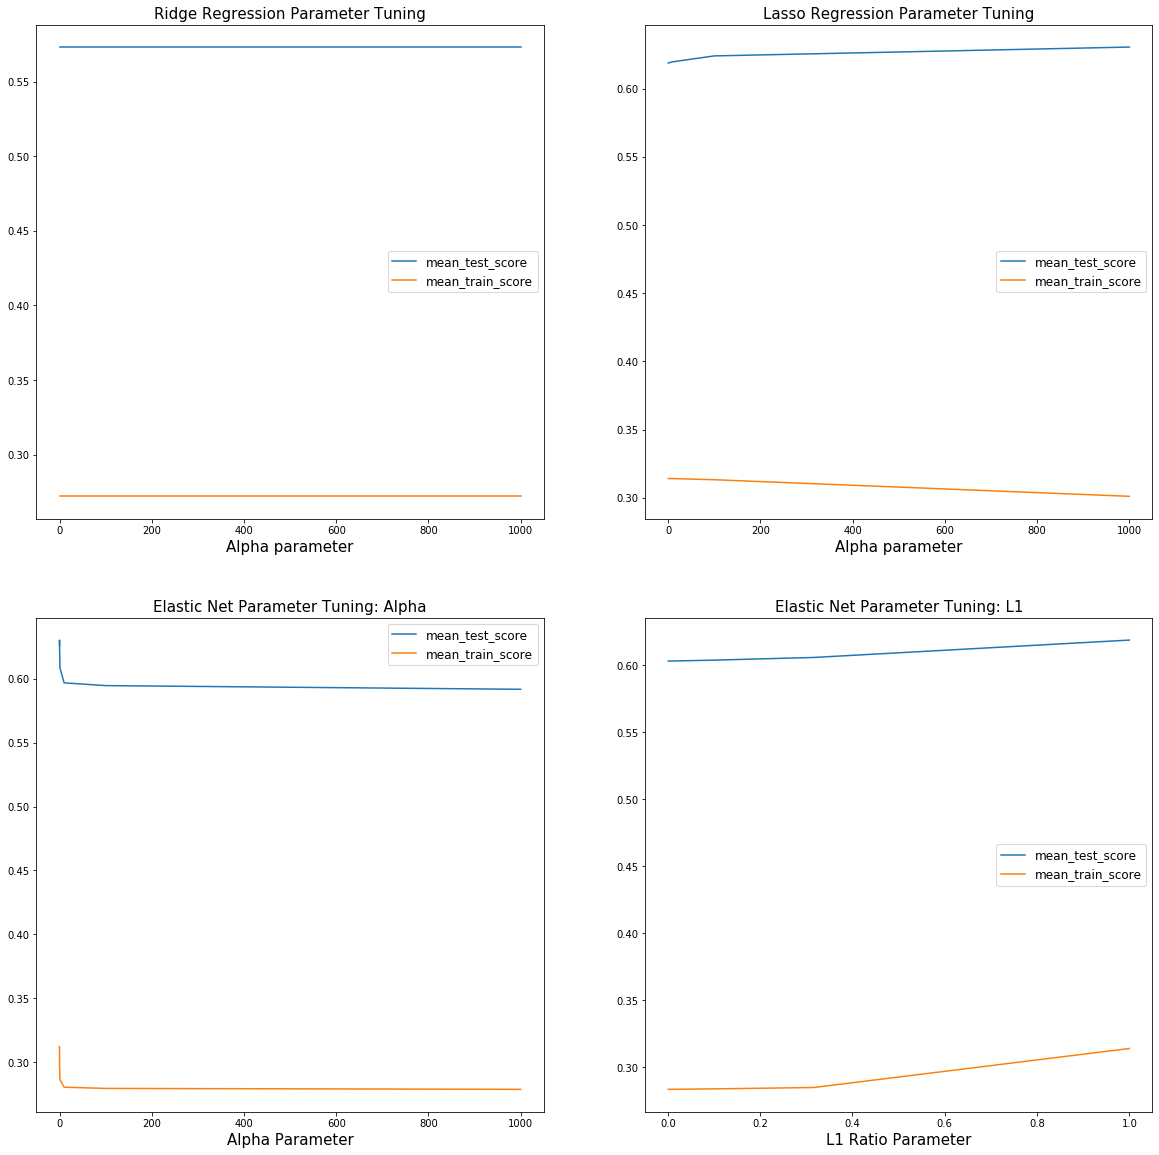

In [69]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax1, ax2, ax3, ax4 = ax.ravel()

ax1.plot(ridge_alpha_param, ridge_mean_test_score)
ax1.plot(ridge_alpha_param, ridge_mean_train_score)
ax1.legend(['mean_test_score', 'mean_train_score'], fontsize=12)
ax1.set_xlabel('Alpha parameter', fontsize=15)
ax1.set_title('Ridge Regression Parameter Tuning', fontsize=15)

ax2.plot(lasso_alpha_param, lasso_mean_test_score)
ax2.plot(lasso_alpha_param, lasso_mean_train_score)
ax2.legend(['mean_test_score', 'mean_train_score'], fontsize=12)
ax2.set_xlabel('Alpha parameter', fontsize=15)
ax2.set_title('Lasso Regression Parameter Tuning', fontsize=15)

ax3.plot(en_alpha_param, en_mean_test_score)
ax3.plot(en_alpha_param, en_mean_train_score)
ax3.legend(['mean_test_score', 'mean_train_score'],fontsize=12)
ax3.set_xlabel('Alpha Parameter', fontsize=15)
ax3.set_title('Elastic Net Parameter Tuning: Alpha', fontsize=15)

ax4.plot(en_l1_param, en_mean_test_score_l1)
ax4.plot(en_l1_param, en_mean_train_score_l1)
ax4.legend(['mean_test_score', 'mean_train_score'],fontsize=12)
ax4.set_xlabel('L1 Ratio Parameter', fontsize=15)
ax4.set_title('Elastic Net Parameter Tuning: L1', fontsize=15)

plt.show()

## 2.6 
Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?

In [57]:
X_new = preprocess.fit_transform(X_train, y_train)
X_new = pd.DataFrame(X_new.toarray())
X_new

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1955.0,1984.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.268470e+05,790.0,6969.0,790.0,0.0
1,1990.0,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,8.019477e+05,1900.0,7604.0,1900.0,0.0
2,1962.0,2000.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.684805e+05,2700.0,10875.0,1540.0,1160.0
3,1997.0,2000.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.315566e+06,4230.0,20377.0,4230.0,0.0
4,1937.0,1998.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.527002e+05,1970.0,23180.0,1100.0,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,2007.0,2000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,5.897857e+05,1270.0,1443.0,1270.0,0.0
3409,1956.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.399148e+05,970.0,5500.0,970.0,0.0
3410,1987.0,2000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,6.269021e+05,2080.0,13189.0,2080.0,0.0
3411,1950.0,1983.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.978214e+06,3070.0,34412.0,2070.0,1000.0


In [70]:
enc = preprocessing.OneHotEncoder()
enc.fit_transform(X_train[categorical])
encoded_categories = list(enc.get_feature_names(categorical))
all_features = year + encoded_categories + state + area

In [71]:
best_ridge_pipe = make_pipeline(preprocess, Ridge(alpha=0.1))
best_ridge_pipe.fit(X_train,y_train)
best_lasso_pipe = make_pipeline(preprocess, Lasso(alpha=1000))
best_lasso_pipe.fit(X_train,y_train)
best_en_pipe = make_pipeline(preprocess, ElasticNet(alpha=0.01, l1_ratio=1))
best_en_pipe.fit(X_train,y_train)

best_ridge_coeff = best_ridge_pipe['ridge'].coef_
best_lasso_coeff = best_lasso_pipe['lasso'].coef_
best_en_coeff = best_en_pipe['elasticnet'].coef_

In [72]:
ridge_coeff_abs = [abs(x) for x in best_ridge_coeff]
ridge_coeff_pairs = zip(all_features, ridge_coeff_abs)
ridge_coeff_sorted = sorted(ridge_coeff_pairs, key=lambda x: x[1], reverse=True)
top_20_ridge = ridge_coeff_sorted[0:21]

lasso_coeff_abs = [abs(x) for x in best_lasso_coeff]
lasso_coeff_pairs = zip(all_features, lasso_coeff_abs)
lasso_coeff_sorted = sorted(lasso_coeff_pairs, key=lambda x: x[1], reverse=True)
top_20_lasso = lasso_coeff_sorted[0:21]

en_coeff_abs = [abs(x) for x in best_en_coeff]
en_coeff_pairs = zip(all_features, en_coeff_abs)
en_coeff_sorted = sorted(en_coeff_pairs, key=lambda x: x[1], reverse=True)
top_20_en = en_coeff_sorted[0:21]

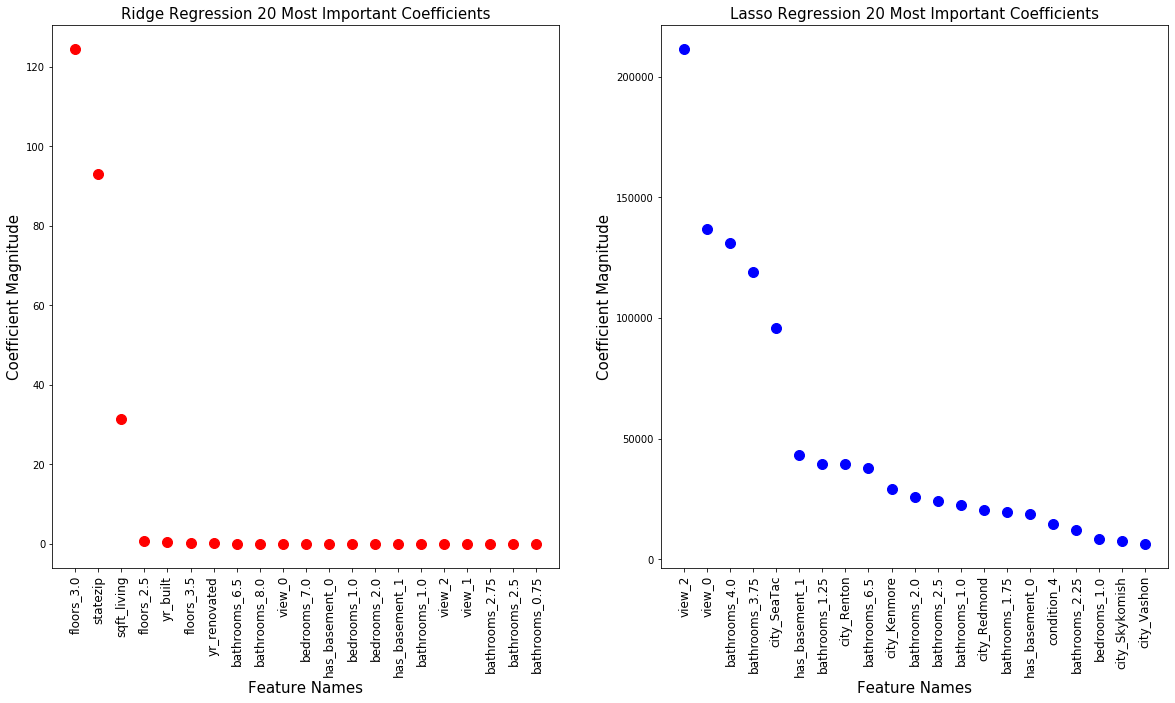

In [73]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax1, ax2 = ax.ravel()

names_ridge, coeff_ridge = zip(*top_20_ridge)
ax1.plot(coeff_ridge, 'ro', markersize='10')
ax1.set_xlabel('Feature Names',fontsize=15)
ax1.set_ylabel('Coefficient Magnitude',fontsize=15)
ax1.set_xticks(range(21))
ax1.set_xticklabels(names_ridge, rotation='vertical', fontsize=12)
ax1.set_title('Ridge Regression 20 Most Important Coefficients',fontsize=15)

names_lasso, coeff_lasso = zip(*top_20_lasso)
ax2.plot(coeff_lasso, 'bo', markersize='10')
ax2.set_xlabel('Feature Names', fontsize=15)
ax2.set_ylabel('Coefficient Magnitude', fontsize=15)
ax2.set_xticks(range(21))
ax2.set_xticklabels(names_lasso, rotation=90, fontsize=12)
ax2.set_title('Lasso Regression 20 Most Important Coefficients', fontsize=15)
plt.show()

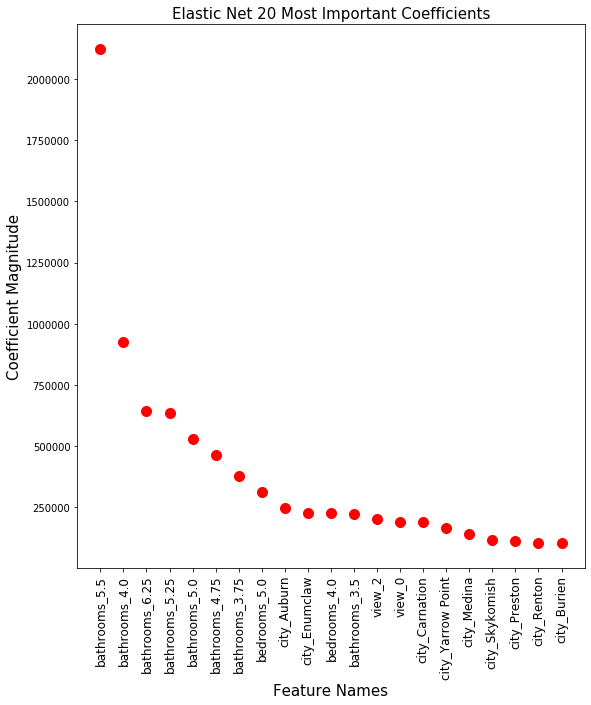

In [74]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax1, ax2 = ax.ravel()

names_en, coeff_en = zip(*top_20_en)
ax1.plot(coeff_en, 'ro', markersize='10')
ax1.set_xlabel('Feature Names',fontsize=15)
ax1.set_ylabel('Coefficient Magnitude',fontsize=15)
ax1.set_xticks(range(21))
ax1.set_xticklabels(names_en, rotation='vertical', fontsize=12)
ax1.set_title('Elastic Net 20 Most Important Coefficients',fontsize=15)
fig.delaxes(ax2)
plt.show()

## Do they agree on which features are important?